In this notebook we explore and train models with a dataset of time series aggregated by time window and transaction category, called super-category based on 

https://www.youtube.com/watch?v=flMCYqIn3eg

Time series can be aggregated by day, week or month which should be taken into account when building tensors

We also consider using the business rules features in order to further upgrade our predictions



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from scipy.stats import norm
import random
import joblib
import timeit

sns.set()


In [15]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,\
                            recall_score, f1_score,roc_curve, auc, roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU ,LeakyReLU, Dropout, Bidirectional, Flatten
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


# Load data and pre process

In [17]:
pd_risk = pd.read_csv('business_rules_features.csv',index_col='loan_id')
pd_day_series = pd.read_csv('pd_day_series.csv',index_col=0,header=[0,1])
pd_week_series = pd.read_csv('pd_week_series.csv',index_col=0,header=[0,1])
pd_month_series = pd.read_csv('pd_month_series.csv',index_col=0,header=[0,1])


In [18]:
def risk_train_test_split(df):
    # g_ids are the customer ids for the "good" clients
    # we return a train test split based on the business rules (risk)
    df_dataset = df[df['risk']>0].copy()
    # now do another train test split over this to get validation and training sets
    X = df_dataset.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    Y = df_dataset['loan_status'].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    # Finally, save clients who do not pass business rules as a validation set
    df_evaluation= df[df['risk']==0].copy()
    X_evaluation = df_evaluation.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    y_evaluation = df_evaluation['loan_status'].copy()

    return X_train, X_test, y_train, y_test, X_evaluation, y_evaluation

def old_risk_train_test_split(df, g_ids):
    # g_ids are the customer ids for the "good" clients
    # we return a train test split based on the business rules (risk)
    df_training = df[(df['risk']>0) & (~df['customer_id'].isin(g_ids))].copy()
    X_training = df_training.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    Y_training = df_training['loan_status'].copy()
    
    # get some of the previously identified good clients and put them in test to evaluate properly
    good_clients = df[df['customer_id'].isin(g_ids)].copy()
    good_client_loans = list(good_clients.index)
    df_test = df[df['risk']==0].copy()
    df_test = pd.concat([df_test,good_clients], axis=0)
    # final dataframes
    X_test = df_test.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    Y_test = df_test['loan_status'].copy()
    
    return X_training, X_test, Y_training, Y_test


### Create the data for a support vector machine

In [19]:
def create_svm_data(time_df,rdf):
    df = time_df.copy()
    columns_tuple = df.columns.values
    df.columns = ['_'.join(col) for col in columns_tuple]
    
    return pd.concat([rdf[['loan_status','taken_at','customer_id_y', 'risk']],df],axis=1)


In [20]:
svm_days = create_svm_data(pd_day_series,pd_risk)
svm_days = svm_days.rename(columns={'customer_id_y':'customer_id'})

svm_weeks = create_svm_data(pd_week_series,pd_risk)
svm_weeks = svm_weeks.rename(columns={'customer_id_y':'customer_id'})

svm_months = create_svm_data(pd_month_series,pd_risk)
svm_months = svm_months.rename(columns={'customer_id_y':'customer_id'})

In [21]:
print(len(svm_days))
print(len(svm_weeks))
print(len(svm_months))


1346
1346
1346


# Evaluation funcs

In [22]:
def plot_roc_curve(y_train_true, y_train_probas, y_test_true, y_test_probas):
    # y_true: series with the true labels encoded in 0 and 1
    # y_probas: probability estimates by the model
    
    # train roc calculattion
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_probas)
    auc_train = roc_auc_score(y_train_true, y_train_probas)
    auc_train = auc_train.round(3)

    # test roc calculattion
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_probas)
    auc_test = roc_auc_score(y_test_true, y_test_probas)
    auc_test = auc_test.round(3)
    
    plt.figure(figsize=(8,7))
    plt.title('roc_curve')
    #plot train
    plt.plot(fpr_train, tpr_train, label='train_auc={}'.format(auc_train), color='orangered')
    
    # plot test
    plt.plot(fpr_test, tpr_test, label='test_auc={}'.format(auc_test), color='mediumorchid')
    # plot baseline
    plt.plot([0, 1], [0, 1], 'k--')
    
    # format axis
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
matplotlib.rcParams['figure.figsize'] = (15, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    # for keras models
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='orange', linestyle=":", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)

        plt.ylim([0.3,1.01])

        plt.legend()
        

In [23]:
def keras_model_evaluation(t_model, training_tensor, training_label, test_tensor, test_label, batch_size):
    # model: pre trained keras model
    # training and test tensor: feautures used to train the models
    # training and test label: true labels for both datasets
    # this functions prints some validation metrics and returns dataframes with the predicted probabilities and 
    # labels to compare with the true labels
    
    # score model and log accuracy and parameters
    scores = t_model.evaluate(test_tensor, np.asarray(y_test), verbose=0)
    print("Accuracy:", scores[5] )
    print("Area Under Curve:", scores[8] )
    print()

    # save the predictions to compare with the actual label
    # this is the probability OF FALLING INTO BAD DEBT
    y_train_pred = t_model.predict(training_tensor, batch_size=batch_size)[:,0]
    y_test_pred = t_model.predict(test_tensor, batch_size=batch_size)[:,0]

    train_results_baseline = pd.DataFrame({'true_label':y_train, 'predicted_proba':y_train_pred}, 
                                          index=y_train.index)
    train_results_baseline['predicted_label'] = 0
    train_results_baseline.loc[train_results_baseline['predicted_proba']>=0.5,'predicted_label'] = 1

    test_results_baseline = pd.DataFrame({'true_label':y_test, 'predicted_proba':y_test_pred}, 
                                          index=y_test.index)

    test_results_baseline['predicted_label'] = 0
    test_results_baseline.loc[test_results_baseline['predicted_proba']>=0.5,'predicted_label'] = 1
    
    return train_results_baseline, test_results_baseline


#  FUNCTIONS for NN'S (BOTH LSTM and CNN)

In [24]:
def build_tensor(df):
    # save category names and then make a list of arrays with the  time series on each category
    categories = df.columns.levels[0]
    catagory_array_list = [np.asarray(df[cat]) for cat in categories]
    # transform the array into the correct tensor shape
    t_tensor = np.concatenate( [arr[None,...] for arr in catagory_array_list] ,axis=0)
    t_tensor = t_tensor.reshape(t_tensor.shape[1], t_tensor.shape[0], t_tensor.shape[2])
    return t_tensor

In [25]:
def init_random(seed):
    # Apparently you may use different seed values at each stage
    seed_value= seed

    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


# SVM training

we sepparate into train and test based on whether the client passes ou business rules or not. Then we take some of 
our good clients from training and put them in test to evaluate more

In [26]:
def calculate_classifier_predictions(trained_model ,X_train, y_train, X_test, y_test): 
    y_train_predict = trained_model.predict(X_train)
    y_train_proba = trained_model.predict_proba(X_train)[:,1]

    print('-----TRAINING RESULTS--------------------------------')

    print(classification_report(y_train, y_train_predict))
    print('auc: ', roc_auc_score(y_train, y_train_proba))
    print(confusion_matrix(y_train, y_train_predict))

    y_test_predict = trained_model.predict(X_test)
    y_test_proba = trained_model.predict_proba(X_test)[:,1]

    print('------TEST RESULTS------------------------------')

    print(classification_report(y_test, y_test_predict ))
    print('auc: ', roc_auc_score(y_test, y_test_proba))
    print(confusion_matrix(y_test, y_test_predict))



In [27]:
# high gamma increases chance of overfitting
# C: controls the permeability of the decision boundary, high values lead to overfiting
svm_params = {'classifier__kernel':['rbf','poly','sigmoid'],
             'classifier__gamma': np.linspace(0.001, 10,10),
              'classifier__C': np.linspace(0.001, 10,10)
             }

In [28]:
good_client_ids = [1270, 1808, 1999, 2052, 2195, 3055, 3453,
       4950, 5070, 5426, 1397,769,1107]
# get the goo client loans
good_client_loans = list(svm_days[svm_days.customer_id.isin(good_client_ids)].index)


### daily agg

In [29]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_days)
svm_days_features = X_train.columns 


In [30]:
svm = SVC(probability=True)
steps_ = [('classifier',svm)]
pipe = Pipeline(steps_) 
params = svm_params
scoring = 'recall_macro'

r_search = RandomizedSearchCV(estimator = pipe, param_distributions = params,n_iter = 15, 
                                  cv=3 ,scoring = scoring, random_state=42, n_jobs = -1)
r_search.fit(X_train, y_train)
print(r_search.best_params_)
calculate_classifier_predictions(r_search, X_train, y_train, X_test, y_test)


{'classifier__kernel': 'poly', 'classifier__gamma': 5.556, 'classifier__C': 7.7780000000000005}
-----TRAINING RESULTS--------------------------------
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       106
           8       1.00      1.00      1.00       631

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

auc:  1.0
[[106   0]
 [  0 631]]
------TEST RESULTS------------------------------
              precision    recall  f1-score   support

           2       0.21      0.27      0.24        26
           8       0.88      0.84      0.86       159

    accuracy                           0.76       185
   macro avg       0.54      0.55      0.55       185
weighted avg       0.78      0.76      0.77       185

auc:  0.5130624092888243
[[  7  19]
 [ 26 133]]


In [31]:
print(r_search.predict(svm_days[svm_days['customer_id'].isin(good_client_ids)][svm_days_features]))
print(r_search.predict_proba(svm_days[svm_days['customer_id'].isin(good_client_ids)][svm_days_features]))

[2 2 2 2 2 8 2 2 2 2 2 2 2]
[[0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.14363784 0.85636216]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]]


### Weekly agg

In [39]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_weeks)
svm_weeks_features = X_train.columns 

In [40]:
svm = SVC(probability=True, kernel='poly')
steps_ = [('scaler', StandardScaler()), ('classifier',svm)]
pipe = Pipeline(steps_) 
pipe.fit(X_train, y_train)

calculate_classifier_predictions(svm, X_train, y_train, X_test, y_test)


-----TRAINING RESULTS--------------------------------
              precision    recall  f1-score   support

           2       0.17      0.93      0.28       106
           8       0.95      0.22      0.36       631

    accuracy                           0.32       737
   macro avg       0.56      0.58      0.32       737
weighted avg       0.84      0.32      0.35       737

auc:  0.5763313697933798
[[ 99   7]
 [493 138]]
------TEST RESULTS------------------------------
              precision    recall  f1-score   support

           2       0.15      0.85      0.25        26
           8       0.88      0.19      0.31       159

    accuracy                           0.28       185
   macro avg       0.51      0.52      0.28       185
weighted avg       0.78      0.28      0.30       185

auc:  0.5174165457184324
[[ 22   4]
 [129  30]]


In [41]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_days)
print(pipe.predict_proba(svm_weeks[svm_weeks['customer_id'].isin(good_client_ids)][svm_weeks_features]))


[[0.13955873 0.86044127]
 [0.1443565  0.8556435 ]
 [0.28290768 0.71709232]
 [0.1496071  0.8503929 ]
 [0.13962599 0.86037401]
 [0.13961853 0.86038147]
 [0.13952017 0.86047983]
 [0.28288113 0.71711887]
 [0.28285823 0.71714177]
 [0.15414542 0.84585458]
 [0.13945704 0.86054296]
 [0.31488306 0.68511694]
 [0.28285285 0.71714715]]


### Monthly agg

In [43]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_months)
svm_months_features = X_train.columns 

In [44]:
svm = SVC(probability=True, kernel='poly')
steps_ = [('scaler', StandardScaler()), ('classifier',svm)]
pipe = Pipeline(steps_) 
pipe.fit(X_train, y_train)

calculate_classifier_predictions(svm, X_train, y_train, X_test, y_test)

-----TRAINING RESULTS--------------------------------
              precision    recall  f1-score   support

           2       0.17      0.89      0.28       106
           8       0.93      0.26      0.41       631

    accuracy                           0.35       737
   macro avg       0.55      0.57      0.35       737
weighted avg       0.82      0.35      0.39       737

auc:  0.5741410758604193
[[ 94  12]
 [466 165]]
------TEST RESULTS------------------------------
              precision    recall  f1-score   support

           2       0.15      0.81      0.25        26
           8       0.88      0.23      0.36       159

    accuracy                           0.31       185
   macro avg       0.51      0.52      0.30       185
weighted avg       0.78      0.31      0.34       185

auc:  0.5170537010159652
[[ 21   5]
 [123  36]]


In [45]:
print(svm.predict(svm_months[svm_months['customer_id'].isin(good_client_ids)][svm_months_features]))
print(svm.predict_proba(svm_months[svm_months['customer_id'].isin(good_client_ids)][svm_months_features]))

[2 2 2 2 2 2 2 2 2 2 2 2 2]
[[9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]]


# LSTM 

First, we create the data set  that the LSTM wil receive. We have to split according to the risk factor
(training with most of the clients that pass the business rules), normalize the data, enconde the label with 0 and
1 and finally transform he time series into the correct tensor shape.

**bidireccionales:** es otra capa para empaquetar el LSTM 



In [46]:

# svm days es simplemente el dataframe de days con las columnas colapsadas y con el risk ahí pegado
time_window_svm = svm_days.copy()
time_window_series = pd_day_series.copy()
# get the training and test indices
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(time_window_svm)

# scale the data  to send it to the LSTM
tensor_scaler = StandardScaler()
X_train = pd.DataFrame(tensor_scaler.fit_transform(X_train), columns=time_window_series.columns ,index=X_train.index)
X_test = pd.DataFrame(tensor_scaler.transform(X_test), columns = time_window_series.columns ,index=X_test.index)
X_evaluation = pd.DataFrame(tensor_scaler.transform(X_evaluation), columns = time_window_series.columns 
                            , index=X_evaluation.index)

X_train = pd.DataFrame(X_train, columns=time_window_series.columns ,index=X_train.index)
X_test = pd.DataFrame(X_test, columns = time_window_series.columns ,index=X_test.index)
X_evaluation = pd.DataFrame(X_evaluation, columns = time_window_series.columns ,index=X_evaluation.index)
# now we encode the label into 1 and 0 where:
# 8 -----> 1  (the event that a client falls into bad debt)
# 2 -----> 0 (a client is a good payer)

y_train.loc[y_train==8]=1
y_train.loc[y_train==2]=0

y_test.loc[y_test==8]=1
y_test.loc[y_test==2]=0

y_evaluation.loc[y_evaluation==8]=1
y_evaluation.loc[y_evaluation==2]=0

print('train test length:')
print(len(y_train), len(y_test))

print('labels:')
print('train')
print(y_train.value_counts())
print('test')
print(y_test.value_counts())
print('eval')
print(y_evaluation.value_counts())

# transform into the correct tensor shape
Tensor_train = build_tensor(X_train)
Tensor_test = build_tensor(X_test)
Tensor_evaluation = build_tensor(X_evaluation)


print('tensor shapes:')
print(Tensor_train.shape)
print(Tensor_test.shape)


train test length:
737 185
labels:
train
1    631
0    106
Name: loan_status, dtype: int64
test
1    159
0     26
Name: loan_status, dtype: int64
eval
1    328
0     96
Name: loan_status, dtype: int64
tensor shapes:
(737, 6, 90)
(185, 6, 90)


Now, we try to build the LSTM. We will have a layer compossed of memory cells (the basic computation unit of an LSTM) which will receive our time series tensor data. The output of the LSTM layer will correspond to the input of a densely connected layer which will have an output of one neuron (the classification task).



## Baseline

In [60]:
def build_lstm(epochs, batch_size, hidden_layer_size, num_layers, 
               use_dropout, learnin_rate, reg ,weights_name, time_steps, features):
    # hidden layer size should be a list with the sizes for each hidden layer
    # metrics
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]

    # build the LSTM layers
    model = Sequential()
    if num_layers==1:
        model.add(Bidirectional(LSTM(hidden_layer_size[0], input_shape=(features, time_steps), kernel_regularizer=reg)))
    # add more than 1 layer
    else:
        for i in range(num_layers-1):
            # all the layers before the last one should return a sequence
            model.add(Bidirectional(LSTM(hidden_layer_size[i], 
                                         input_shape=(features, time_steps),return_sequences=True)))
        # final LSTM
        model.add(LSTM(hidden_layer_size[i+1], input_shape=(features, time_steps)))         
        
    if use_dropout:
        model.add(Dropout(0.3))
        # the output is a dense layer with one neuron
        
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # compile the algorithm
    optimizer = Adam(lr=learnin_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[METRICS])
    
    return model


In [70]:
# define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)


In [82]:
# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 20
NUM_LAYERS = 1
HIDDEN_LAYER_SIZES = [10]
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]
# no reg
REG = L1L2(l1=0.001, l2=0.0)

USE_DROPOUT = True
LEARNING_RATE = 0.001

# name of the files to save
weights_name = 'weights_lstm.h5'


In [83]:
# compile the model 
tf.keras.backend.clear_session()
init_random(1234)

# build the model
model = build_lstm(EPOCHS, BATCH_SIZE, HIDDEN_LAYER_SIZES, NUM_LAYERS, USE_DROPOUT, LEARNING_RATE, REG,
                   weights_name, TIME_STEPS, FEATURES)


In [ ]:
# train
print('time start')
start = timeit.default_timer()

history = model.fit(Tensor_train, np.asarray(y_train), validation_data=(Tensor_test, np.asarray(y_test)),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

stop = timeit.default_timer()



time start
Train on 737 samples, validate on 185 samples
Epoch 1/300
737/737 [==============================] - 14s 19ms/sample - loss: 1.3530 - tp: 462.0000 - fp: 68.0000 - tn: 38.0000 - fn: 169.0000 - accuracy: 0.6784 - precision: 0.8717 - recall: 0.7322 - auc: 0.5281 - val_loss: 1.2432 - val_tp: 142.0000 - val_fp: 22.0000 - val_tn: 4.0000 - val_fn: 17.0000 - val_accuracy: 0.7892 - val_precision: 0.8659 - val_recall: 0.8931 - val_auc: 0.5308
Epoch 2/300
737/737 [==============================] - 1s 1ms/sample - loss: 1.1568 - tp: 560.0000 - fp: 92.0000 - tn: 14.0000 - fn: 71.0000 - accuracy: 0.7788 - precision: 0.8589 - recall: 0.8875 - auc: 0.5639 - val_loss: 1.0774 - val_tp: 150.0000 - val_fp: 25.0000 - val_tn: 1.0000 - val_fn: 9.0000 - val_accuracy: 0.8162 - val_precision: 0.8571 - val_recall: 0.9434 - val_auc: 0.5229
Epoch 3/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.9941 - tp: 611.0000 - fp: 92.0000 - tn: 14.0000 - fn: 20.0000 - accuracy: 0.8480 - pre

Epoch 22/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.2556 - tp: 625.0000 - fp: 20.0000 - tn: 86.0000 - fn: 6.0000 - accuracy: 0.9647 - precision: 0.9690 - recall: 0.9905 - auc: 0.9820 - val_loss: 0.8076 - val_tp: 144.0000 - val_fp: 22.0000 - val_tn: 4.0000 - val_fn: 15.0000 - val_accuracy: 0.8000 - val_precision: 0.8675 - val_recall: 0.9057 - val_auc: 0.5233
Epoch 23/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.2436 - tp: 627.0000 - fp: 16.0000 - tn: 90.0000 - fn: 4.0000 - accuracy: 0.9729 - precision: 0.9751 - recall: 0.9937 - auc: 0.9839 - val_loss: 0.8531 - val_tp: 143.0000 - val_fp: 22.0000 - val_tn: 4.0000 - val_fn: 16.0000 - val_accuracy: 0.7946 - val_precision: 0.8667 - val_recall: 0.8994 - val_auc: 0.5076
Epoch 24/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.2298 - tp: 630.0000 - fp: 14.0000 - tn: 92.0000 - fn: 1.0000 - accuracy: 0.9796 - precision: 0.9783 - recall: 0.9984 - auc: 0.9857 - val_loss: 0

737/737 [==============================] - 3s 4ms/sample - loss: 0.1227 - tp: 631.0000 - fp: 3.0000 - tn: 103.0000 - fn: 0.0000e+00 - accuracy: 0.9959 - precision: 0.9953 - recall: 1.0000 - auc: 0.9987 - val_loss: 1.1571 - val_tp: 139.0000 - val_fp: 20.0000 - val_tn: 6.0000 - val_fn: 20.0000 - val_accuracy: 0.7838 - val_precision: 0.8742 - val_recall: 0.8742 - val_auc: 0.5329
Epoch 44/300
737/737 [==============================] - 3s 3ms/sample - loss: 0.1211 - tp: 628.0000 - fp: 3.0000 - tn: 103.0000 - fn: 3.0000 - accuracy: 0.9919 - precision: 0.9952 - recall: 0.9952 - auc: 0.9991 - val_loss: 1.1522 - val_tp: 145.0000 - val_fp: 22.0000 - val_tn: 4.0000 - val_fn: 14.0000 - val_accuracy: 0.8054 - val_precision: 0.8683 - val_recall: 0.9119 - val_auc: 0.5356
Epoch 45/300
737/737 [==============================] - 1s 2ms/sample - loss: 0.1204 - tp: 630.0000 - fp: 3.0000 - tn: 103.0000 - fn: 1.0000 - accuracy: 0.9946 - precision: 0.9953 - recall: 0.9984 - auc: 0.9988 - val_loss: 1.1601 - v

In [ ]:
print('training took: ', stop - start)
print(model.summary())

plot_metrics(history)

**Evaluate the model**

We the confussion matriz, se the ROC curve and finally we take a look at the good clients to see how the model performs

In [ ]:
train_results_baseline, test_results_baseline = keras_model_evaluation(model, Tensor_train, 
                                                                       y_train, Tensor_test, y_test,BATCH_SIZE)
train_results_baseline.columns

In [ ]:
# plot the probability distributions in training and test
current_df = train_results_baseline
plt.figure(figsize=(11,5))
plt.title('Probability of falling into bad debt training')
sns.kdeplot(current_df[current_df.true_label==1]['predicted_proba'],color='red' ,label='bad clients')
sns.kdeplot(current_df[current_df.true_label==0]['predicted_proba'],color='blue' ,label='good clients')

current_df = test_results_baseline

plt.figure(figsize=(11,5))
plt.title('Probability of falling into bad debt test')
sns.kdeplot(current_df[current_df.true_label==1]['predicted_proba'],color='red' ,label='bad clients')
sns.kdeplot(current_df[current_df.true_label==0]['predicted_proba'],color='blue' ,label='good clients')


In [ ]:
print('Train confussion matrix: ')
print(confusion_matrix(train_results_baseline['true_label'], train_results_baseline['predicted_label']))
print('test confussion matrix: ')
print(confusion_matrix(test_results_baseline['true_label'], test_results_baseline['predicted_label']))

print('ROC z=15')    
plot_roc_curve(train_results_baseline['true_label'], train_results_baseline['predicted_proba'],
               test_results_baseline['true_label'], test_results_baseline['predicted_proba'])


In [ ]:
# test for our "good" clients
test_results_baseline[test_results_baseline.index.isin(good_client_loans)]


## Optimized

we try to uprade the model by tuning the hyper parameters and architecture

1. increase num of neurons: for 1 hidden layer 10 neurons gives the best performance
2. increase num of layers
3. tune droput
4. regularization
5. Tune learning rate
6. tune batch size
7. use sample weights


First optimize number of neurons for 2 layers. We use the AUC for both training and test sets to find the "best" model.

### hidden layers and number of neurons
for 2 hidden layers find best configuration of neurons

In [158]:
metrics_dict = {'first_layer_neurons':[], 'second_layer_neurons':[], 'train_auc':[], 'test_auc':[]}

In [210]:

# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 32
NUM_LAYERS = 2
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]
REG = L1L2(l1=0.0, l2=0.0)

USE_DROPOUT = True
LEARNING_RATE = 0.001
# name of the files to save
weights_name = 'weights_lstm_optimized.h5'

# for each size of first layer, iterate over all the seond layer sizes
first_layer_sizes = [2,5,10,15]
second_layer_sizes = [2,5,10,15]

for h1 in first_layer_sizes:
    for h2 in second_layer_sizes:
        print('init')
        HIDDEN_LAYER_SIZES = [h1, h2]
        # compile the model 
        tf.keras.backend.clear_session()
        init_random(1234)
        # build the model
        model = build_lstm(EPOCHS, BATCH_SIZE, HIDDEN_LAYER_SIZES, NUM_LAYERS, USE_DROPOUT, LEARNING_RATE, REG,
                           weights_name, TIME_STEPS, FEATURES)
        # train the model
        start = timeit.default_timer()
        history = model.fit(Tensor_train, np.asarray(y_train), validation_data=(Tensor_test, np.asarray(y_test)),
                    epochs=EPOCHS, batch_size=batch_size, callbacks=[early_stopping], verbose = 0)
        stop = timeit.default_timer()
        
        scores = model.evaluate(Tensor_train, np.asarray(y_train), verbose=0)
        print("test Accuracy:", scores[5] )
        print("test Area Under Curve:", scores[8] )
        
        metrics_dict['train_auc'].append(scores[8])
        
        scores = model.evaluate(Tensor_test, np.asarray(y_test), verbose=0)
        print("test Accuracy:", scores[5] )
        print("test Area Under Curve:", scores[8] )
        metrics_dict['test_auc'].append(scores[8])
        
        # append neurons
        metrics_dict['first_layer_neurons'].append(h1)
        metrics_dict['second_layer_neurons'].append(h2)
             


init
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
test Accuracy: 0.88008803
test Area Under Curve: 0.6961334
test Accuracy: 0.7505721
test Area Under Curve: 0.6999329
init
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
test Accuracy: 0.8690869
test Area Under Curve: 0.6031114
test Accuracy: 0.7505721
test Area Under Curve: 0.7209107
init
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
test Accuracy: 0.8811881
test Area Under Curve: 0.6803425
test Accuracy: 0.75514877
test Area Under Curve: 0.7188828
init
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
test Accuracy: 0.87678766
test Area Under Curve: 0.7013296
test Accuracy: 0.7505721
test Area Under Curve: 0.7062542
init
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
test Accuracy: 0.88448846
test Area Under Curve: 0.7441176
test Accuracy: 0.7597254
test

In [215]:
print(np.argmax(metrics_dict['test_auc']))
print(np.argmax(metrics_dict['train_auc']))

print('test auc: ',metrics_dict['test_auc'][57], 'train aux:' ,metrics_dict['train_auc'][57],
         'n h1: ', metrics_dict['first_layer_neurons'][57], 'n h1: ', metrics_dict['second_layer_neurons'][57])

print('test auc: ',metrics_dict['test_auc'][53], 'train aux:' ,metrics_dict['train_auc'][53],
         'n h1: ', metrics_dict['first_layer_neurons'][53], 'n h1: ', metrics_dict['second_layer_neurons'][53])

57
53
test auc:  0.7285327 train aux: 0.61602485 n h1:  11 n h1:  11
test auc:  0.7111071 train aux: 0.7441176 n h1:  10 n h1:  10


### Drop out and regularization and learning rate

It was found that the best model has 1 layer and 10 neurons. We now try to reduce overfitting

In [273]:
# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 32
NUM_LAYERS = 1
HIDDEN_LAYER_SIZES = [10]
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]
REG = L1L2(l1=0.01, l2=0.0)

USE_DROPOUT = True
LEARNING_RATE = 0.001

# name of the files to save
weights_name = 'weights_lstm.h5'

# compile the model 
tf.keras.backend.clear_session()
init_random(1234)

# build the model
model = build_lstm(EPOCHS, BATCH_SIZE, HIDDEN_LAYER_SIZES, NUM_LAYERS, USE_DROPOUT, LEARNING_RATE, REG,
                   weights_name, TIME_STEPS, FEATURES)


In [274]:
# train
print('time start')
start = timeit.default_timer()

history = model.fit(Tensor_train, np.asarray(y_train), validation_data=(Tensor_test, np.asarray(y_test)),
                    epochs=EPOCHS, batch_size=batch_size, callbacks=[early_stopping])

stop = timeit.default_timer()


time start
Train on 909 samples, validate on 437 samples
Epoch 1/300
909/909 [==============================] - 18s 20ms/sample - loss: 7.4755 - tp: 507.0000 - fp: 73.0000 - tn: 46.0000 - fn: 283.0000 - accuracy: 0.6084 - precision: 0.8741 - recall: 0.6418 - auc: 0.5378 - val_loss: 6.5087 - val_tp: 284.0000 - val_fp: 87.0000 - val_tn: 22.0000 - val_fn: 44.0000 - val_accuracy: 0.7002 - val_precision: 0.7655 - val_recall: 0.8659 - val_auc: 0.6115
Epoch 2/300
909/909 [==============================] - 1s 1ms/sample - loss: 5.7107 - tp: 643.0000 - fp: 88.0000 - tn: 31.0000 - fn: 147.0000 - accuracy: 0.7415 - precision: 0.8796 - recall: 0.8139 - auc: 0.5639 - val_loss: 4.8860 - val_tp: 315.0000 - val_fp: 101.0000 - val_tn: 8.0000 - val_fn: 13.0000 - val_accuracy: 0.7391 - val_precision: 0.7572 - val_recall: 0.9604 - val_auc: 0.6503
Epoch 3/300
909/909 [==============================] - 1s 1ms/sample - loss: 4.1945 - tp: 734.0000 - fp: 106.0000 - tn: 13.0000 - fn: 56.0000 - accuracy: 0.8218 

909/909 [==============================] - 1s 1ms/sample - loss: 0.4094 - tp: 790.0000 - fp: 119.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8691 - precision: 0.8691 - recall: 1.0000 - auc: 0.5633 - val_loss: 0.6402 - val_tp: 328.0000 - val_fp: 109.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7506 - val_precision: 0.7506 - val_recall: 1.0000 - val_auc: 0.3842
Epoch 22/300
909/909 [==============================] - 1s 1ms/sample - loss: 0.4142 - tp: 790.0000 - fp: 119.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8691 - precision: 0.8691 - recall: 1.0000 - auc: 0.5290 - val_loss: 0.6326 - val_tp: 328.0000 - val_fp: 109.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7506 - val_precision: 0.7506 - val_recall: 1.0000 - val_auc: 0.3355
Epoch 23/300
909/909 [==============================] - 1s 1ms/sample - loss: 0.4154 - tp: 790.0000 - fp: 119.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8691 - precision: 0.8691 - recall: 1.0000 

training took:  56.31192269799976
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  8080      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  21        
Total params: 8,101
Trainable params: 8,101
Non-trainable params: 0
_________________________________________________________________
None


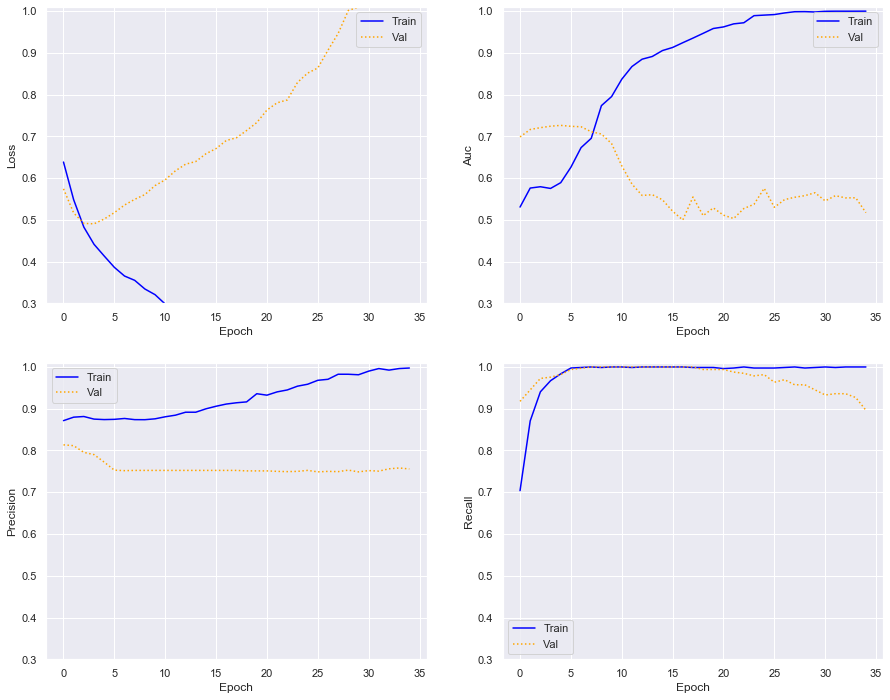

In [243]:
print('training took: ', stop - start)
print(model.summary())
plot_metrics(history)

Accuracy: 0.7688787
Area Under Curve: 0.72650486

Train confussion matrix: 
[[  5 114]
 [  1 789]]
test confussion matrix: 
[[ 14  95]
 [  6 322]]
ROC z=15


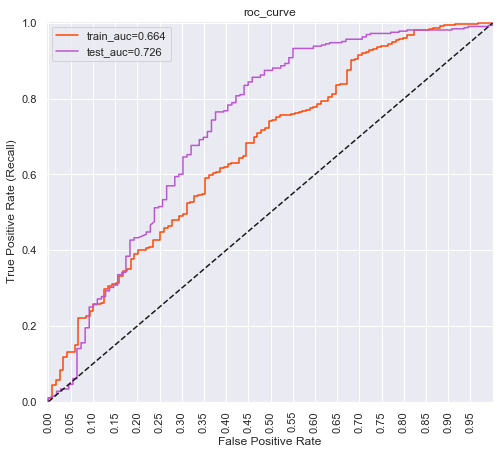

In [244]:
train_results_baseline, test_results_baseline = keras_model_evaluation(model, Tensor_train, 
                                                                       y_train, Tensor_test, y_test)
print('Train confussion matrix: ')
print(confusion_matrix(train_results_baseline['true_label'], train_results_baseline['predicted_label']))
print('test confussion matrix: ')
print(confusion_matrix(test_results_baseline['true_label'], test_results_baseline['predicted_label']))

print('ROC z=15')    
plot_roc_curve(train_results_baseline['true_label'], train_results_baseline['predicted_proba'],
               test_results_baseline['true_label'], test_results_baseline['predicted_proba'])

### batch size